# Getting in Trump's Head

## Analyse et modélisation des discours de Donald Trump

**Auteurs** : Nicolas Grimaldi, Amjad Benhafessa

---

### Problématique

Comment caractériser le style oratoire de Donald Trump et peut-on prédire la suite d'une phrase qu'il prononce ?

Ce projet explore les discours publics de Trump à travers:
1. **La collecte de données** via webscraping du site Roll Call
2. **L'analyse descriptive** du corpus (durée, fréquence des mots, évolution temporelle)
3. **La comparaison** avec Biden et Kamala Harris
4. **La modélisation** par N-grammes pour prédire la fin d'une phrase

---

## Partie 1 : Collecte des données (Scraping)

Le site [Roll Call](https://rollcall.com/factbase/) archive les transcriptions des discours politiques américains.

### Architecture du scraping

On utilise **Selenium** pour naviguer sur le site (JavaScript dynamique) et **BeautifulSoup** pour parser le HTML.

Le scraping se fait en 2 étapes :
1. `speech_url_scrap.py` : Récupère la liste des URLs des discours
2. `process_speeches.py` : Pour chaque URL, extrait le titre, la date, les catégories et les transcriptions

In [2]:
import sys, os
import pandas as pd
import numpy as np
import sqlite3
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

sys.path.insert(0, os.path.abspath('../src'))

### Démonstration du scraping

Voici comment fonctionne notre pipeline. !! ça prend un peu de temps (~5 min) et parfois ça crash !!

In [56]:
# Nos fonctions de scraping
from rollcall.browser_setup import get_browser
from rollcall.speech_filter_action import open_page_close_popup_and_click_filters
from rollcall.scroller import scroll_to_bottom
from rollcall.url_extractor import extract_urls
from rollcall.storage import store_urls
from rollcall.speeches_db import init_db

# Exemple de code pour scraper
# 1. On ouvre le navigateur
browser = get_browser()

# 2. On navigue vers la page et on ferme les popups
open_page_close_popup_and_click_filters(browser, 'https://rollcall.com/factbase/trump/search/')

# 3. On scroll jusqu'en bas pour charger tous les résultats
scroll_to_bottom(browser)

# 4. On extrait les URLs
urls = extract_urls(browser)

# 5. On stocke dans la base de données
store_urls(urls, db_path="../data/speeches.db")
print("Le code de scraping est illustré ci-dessus.")
print("Il n'est pas exécuté ici car les données sont déjà collectées.")

InvalidSessionIdException: Message: invalid session id: session deleted as the browser has closed the connection
from disconnected: not connected to DevTools
  (Session info: chrome=143.0.7499.41); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#invalidsessionidexception
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0xf40d13
	0xf40d54
	0xd2e6dd
	0xd1d99e
	0xd3c4e6
	0xda21d8
	0xdbd44c
	0xd9b2e6
	0xd6d321
	0xd6e1d4
	0x1194d54
	0x119030b
	0x11acbea
	0xf5ac18
	0xf62c1d
	0xf49018
	0xf491d9
	0xf33568
	0x768a7ba9
	0x7784c3ab
	0x7784c32f


### Difficultés rencontrées

- **Popups** : Le site affiche des popups qu'il faut fermer avant de pouvoir scroller
- **Scroll infini** : Les résultats se chargent dynamiquement, il faut scroller jusqu'en bas
- **Parsing HTML** : Les classes CSS sont très longues et spécifiques, il faut les copier exactement

---

## Partie 2 : Chargement et nettoyage des données

Les données sont stockées en SQLite et exportées en Parquet pour l'analyse.

In [4]:
db_path = "../data/speeches.db"
conn = sqlite3.connect(db_path)
trump_speeches = pd.read_sql_query("SELECT * FROM Speeches", conn)
conn.close()
print(f"Nombre de discours Trump : {len(trump_speeches)}")
trump_speeches.head()

Nombre de discours Trump : 894


,id,url,title,date,nbr_sentences,nbr_words,nbr_seconds,categories
0,1,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses Service Members...,"October 5, 2025",693,6902,2636,"[""Armed Forces"", ""Waterway and Maritime Transp..."
1,2,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses Military Leader...,"September 30, 2025",1031,12529,4261,"[""Politics"", ""Military Equipment"", ""Government..."
2,3,https://rollcall.com/factbase/trump/transcript...,Speech: JD Vance Discusses Tax Policy and Publ...,"September 24, 2025",,,,"[""Government"", ""Crime"", ""Police"", ""Law Enforce..."
3,4,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses the 80th Sessio...,"September 23, 2025",579,8317,3398,"[""Economy, Business and Finance"", ""Crime"", ""In..."
4,5,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses a Memorial for ...,"September 21, 2025",458,5631,2472,"[""Crime"", ""Religion"", ""Crime, Law and Justice""..."


In [5]:
transcriptions_df = pd.read_parquet('../data/transcriptions_cleaned.parquet')
# On enlève les annotations de type [Applause], [Booing], etc.
transcriptions_df['text'] = transcriptions_df['text'].str.replace(r"\[.*?\]", "", regex=True, flags=re.DOTALL).str.strip()
print(f"Nombre de segments de transcription : {len(transcriptions_df)}")
transcriptions_df.head()

Nombre de segments de transcription : 121034


,id,speech_id,timestamp,duration,text,cleaned_transcription,clean-v1-with-stopwords
0,1,1,00:00:00-00:00:22 (22 sec),None,"Well, that was good timing, wasn't it? We had...",audience chant usa good timing laugh right rig...,well that be good timing be not it we have to ...
1,2,1,00:00:22-00:00:34 (12 sec),None,"We appreciate it. Thank you, Navy. Thank you v...",appreciate thank navy thank wanna thank magnif...,we appreciate it thank you navy thank you very...
2,3,1,00:00:34-00:01:03 (29 sec),None,They do. And let me say to all of the incredib...,let incredible sailor pier great fleet fleet l...,they do and let I say to all of the incredible...
3,4,1,00:01:03-00:01:06 (3 sec),None,"You know, a lot of people don't.",know lot people laugh audience respond affirma...,you know a lot of people do not
4,5,1,00:01:06-00:01:37 (31 sec),None,And it's a true honor to be here with the thou...,true honor thousand nation fine sailor large n...,and it 's a true honor to be here with the tho...


---

## Partie 3 : Analyse descriptive

### 3.1 Combien d'heures de Trump avons-nous ?

In [6]:
import re
#Extraction de la durée depuis le timestamp 
def extract_seconds(ts):
    if not isinstance(ts, str):
        return None
    match = re.search(r'\((\d+) sec\)', ts)
    if match:
        return float(match.group(1))
    return None
transcriptions_df['duration'] = transcriptions_df['timestamp'].apply(extract_seconds)
transcriptions_df['char_len'] = transcriptions_df['text'].fillna('').str.len()
transcriptions_df.sort_values(by='duration')

,id,speech_id,timestamp,duration,text,cleaned_transcription,clean-v1-with-stopwords,char_len
117620,117621,861,00:28:07-00:28:08 (1 sec),1.0,Doubled it.,double,double it,11
120903,120904,894,00:43:27-00:43:28 (1 sec),1.0,Unbelievable.,unbelievable,unbelievable,13
120902,120903,894,00:43:24-00:43:24 (1 sec),1.0,Unbelievable.,unbelievable,unbelievable,13
117636,117637,861,00:35:31-00:35:32 (1 sec),1.0,"Yes, right.",yes right,yes right,11
108262,108263,791,00:12:53-00:12:54 (1 sec),1.0,We won't have to use it.,wo use,we wo not have to use it,24
...,...,...,...,...,...,...,...,...
118743,118744,869,00:22:50-00:22:50 ( sec),NaN,Right.,right,right,6
119338,119339,877,00:01:53-00:01:54 ( sec),NaN,You can do it.,,you can do it,14
119504,119505,879,00:34:34-00:34:34 ( sec),NaN,Thank you.,thank,thank you,10
120827,120828,892,00:42:35-00:42:36 ( sec),NaN,"Thank you, man.",thank man,thank you man,15


In [7]:
missing_count = transcriptions_df['duration'].isna().sum()
print(f"--- Analyse Initiale ---")
print(f"Nombre total de segments : {len(transcriptions_df)}")
print(f"Segments avec durée manquante (NaN) : {missing_count}")

--- Analyse Initiale ---
Nombre total de segments : 121034
Segments avec durée manquante (NaN) : 2439


#### Constat : Des durées manquantes
On remarque qu'il y a des segments où la durée n'est pas indiquée entre parenthèses. 
Pour ne pas perdre cette information, nous allons **imputer** ces durées via une régression linéaire simple basée sur le nombre de caractères (hypothèse : plus le texte est long, plus le segment dure longtemps).

In [8]:
# Imputation des durées manquantes via une régression
mask_train = transcriptions_df['duration'].notna() & (transcriptions_df['duration'] > 0)
df_train = transcriptions_df[mask_train].copy()
df_train['duration'] = df_train['duration'].astype(int)
Y = df_train['duration']
Y_mean = Y.mean()
X = df_train['char_len']
X_mean = X.mean()
    
 # Calcul coefficients
covX_Y = sum((Xi - X_mean) * (Yi - Y_mean) for Xi, Yi in zip(X, Y))
VX = sum((Xi - X_mean)**2 for Xi in X)
b = covX_Y/ VX
a = Y_mean - b * Y_mean  # Formule TP
    
print(f"\nRégression Manuelle : a={a}, b={b}")

# Prédiction
mask_missing = transcriptions_df['duration'].isna()
if mask_missing.any():
    transcriptions_df.loc[mask_missing, 'duration'] = a + b * transcriptions_df.loc[mask_missing, 'char_len']
    print(f"Imputation terminée pour {mask_missing.sum()} segments.")

# Agrégation dans la df de base
speech_totals = transcriptions_df.groupby('speech_id')['duration'].sum().reset_index()
trump_speeches = trump_speeches.merge(speech_totals, left_on='id', right_on='speech_id', how='left')
trump_speeches['nbr_seconds_num'] = pd.to_numeric(trump_speeches['nbr_seconds'], errors='coerce')
trump_speeches['final_duration'] = trump_speeches['duration'].fillna(trump_speeches['nbr_seconds_num'])
print(f"Total estimé : {trump_speeches['final_duration'].sum():,.0f} secondes.")



Régression Manuelle : a=23.081868373764628, b=0.06623834892052424
Imputation terminée pour 2439 segments.
Total estimé : 2,996,813 secondes.


### 3.2 Distribution de la durée des discours

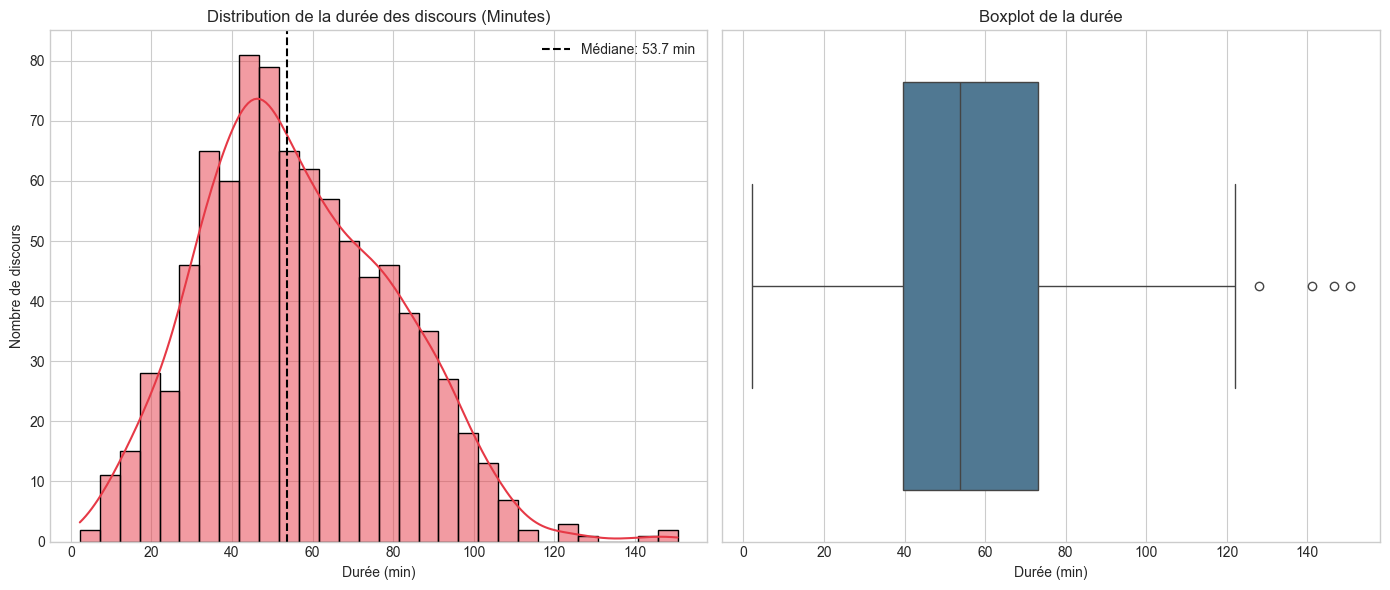

Discours le plus long : 151 minutes
Discours le plus court : 2 minutes


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

trump_speeches['duration_minutes'] = trump_speeches['final_duration'] / 60
plt.figure(figsize=(14, 6))
# hist
plt.subplot(1, 2, 1)
sns.histplot(trump_speeches['duration_minutes'].dropna(), bins=30, color='#E63946', kde=True)
plt.title('Distribution de la durée des discours (Minutes)')
plt.xlabel('Durée (min)')
plt.ylabel('Nombre de discours')
plt.axvline(trump_speeches['duration_minutes'].median(), color='k', linestyle='--', label=f'Médiane: {trump_speeches["duration_minutes"].median():.1f} min')
plt.legend()
# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=trump_speeches['duration_minutes'], color='#457B9D')
plt.title('Boxplot de la durée')
plt.xlabel('Durée (min)')
plt.tight_layout()
plt.show()
print(f"Discours le plus long : {trump_speeches['duration_minutes'].max():.0f} minutes")
print(f"Discours le plus court : {trump_speeches['duration_minutes'].min():.0f} minutes")


### 3.5 Analyse des mots les plus fréquents

Regardons d'abord quels sont les mots les plus utilisés par Trump.

['well,', 'that', 'was', 'good', 'timing,', "wasn't", 'it?', 'we', 'had', 'to']
well, that was good timing, wasn't it? we had to get that right. we had to get that right, but they 
['well', ',', 'that', 'was', 'good', 'timing', ',', 'was', "n't", 'it']


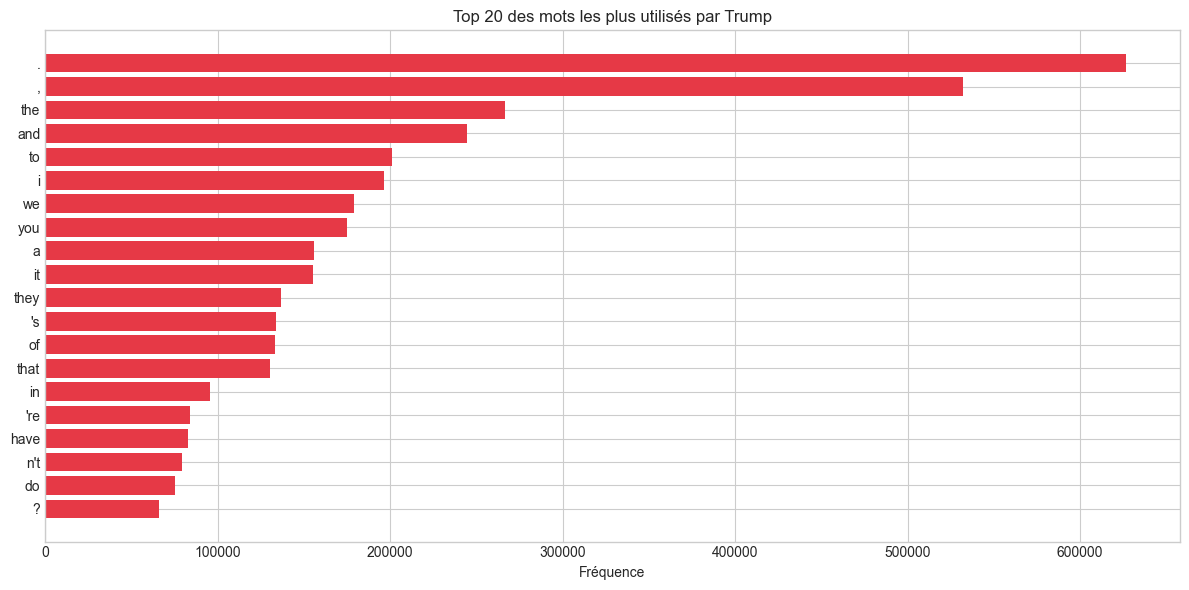

Top 10 :
   .: 626,635
   ,: 532,376
   the: 266,819
   and: 244,596
   to: 200,851
   i: 196,727
   we: 179,096
   you: 174,975
   a: 155,650
   it: 155,571


In [10]:
#On tokenize nos mots
all_words = []
for text in transcriptions_df['text'].dropna():
    all_words.extend(text.lower().split())
print(all_words[:10])
all_text=' '.join(all_words)
print(all_text[:100])
from nltk.tokenize import word_tokenize
all_words=word_tokenize(all_text)
print(all_words[:10])
word_counts_raw = Counter(all_words)
top_20_raw = word_counts_raw.most_common(20)

fig, ax = plt.subplots(figsize=(12, 6))
words, counts = zip(*top_20_raw)
ax.barh(words, counts, color='#E63946')
ax.invert_yaxis()
ax.set_xlabel('Fréquence')
ax.set_title('Top 20 des mots les plus utilisés par Trump')
plt.tight_layout()
plt.show()
print("Top 10 :")
for w, c in top_20_raw[:10]:
    print(f"   {w}: {c:,}")

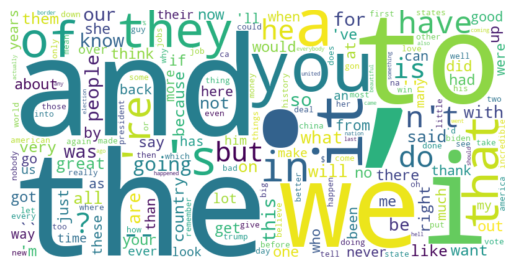

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color="white")
wc = wc.generate_from_frequencies(word_counts_raw)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

**Observation** : Les mots les plus fréquents sont tous des **stop words** (mots vides en anglais) comme "the", "and", "to", "a", "of"...

Ces mots n'apportent aucune information sur le contenu ou le style de Trump. On doit les filtrer pour voir les mots réellement intéressants.

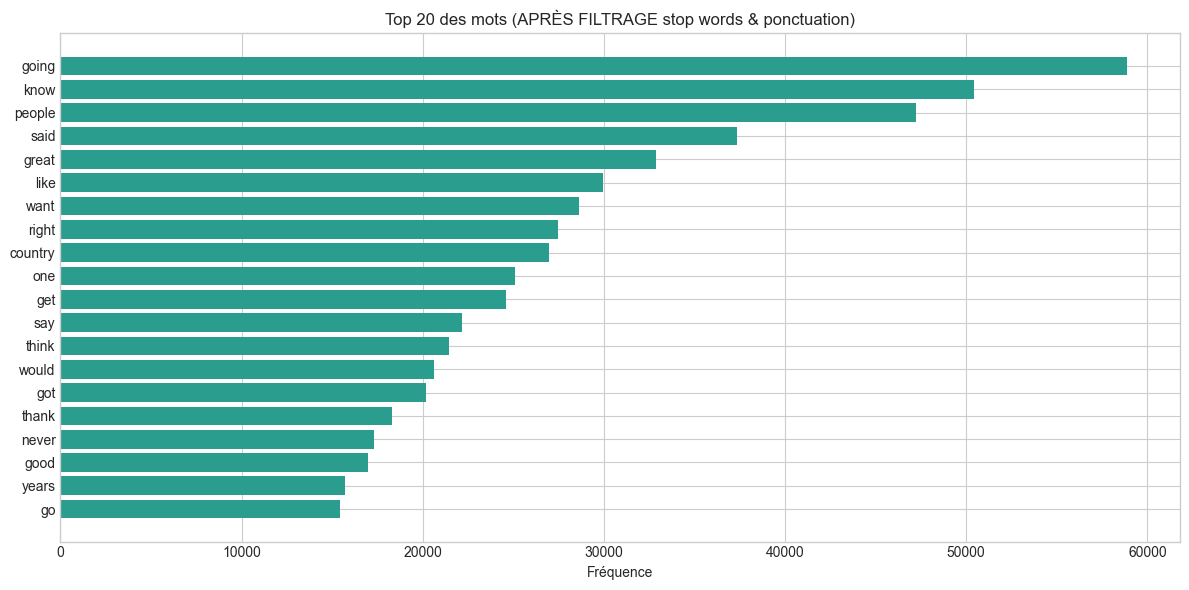

In [27]:
import nltk
from nltk.corpus import stopwords
import string
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation) 
punctuation.update(['``', "''", '--', '...', '“', '”', '’', '—', '–'])
nltk_artifacts = {"'s", "n't", "'re", "'ve", "'m", "'ll", "'d"}
# Filtrage des stop words ET de la ponctuation ET des petits tokens non intéressants
all_words_filtered = [(w, c) for w, c in word_counts_raw.most_common(200) if w.lower() not in stop_words and w not in punctuation and w not in nltk_artifacts]
top_words_filtered = all_words_filtered[:20]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
words, counts = zip(*top_words_filtered)
ax.barh(words, counts, color='#2A9D8F')
ax.invert_yaxis()
ax.set_xlabel('Fréquence')
ax.set_title('Top 20 des mots (APRÈS FILTRAGE stop words & ponctuation)')
plt.tight_layout()
plt.show()



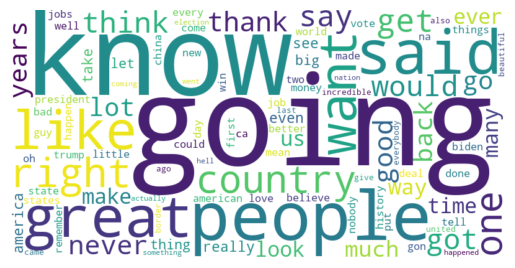

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words_filtered_counter=Counter(dict(all_words_filtered))
wc = WordCloud(width=800, height=400, background_color="white")
wc = wc.generate_from_frequencies(all_words_filtered_counter)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

C'est mieux ! Maintenant on voit des mots qui caractérisent vraiment les discours de Trump : **"people"**, **"country"**, **"great"**, **"president"**, **"America"**, etc.

### 3.7 Longueur moyenne des phrases

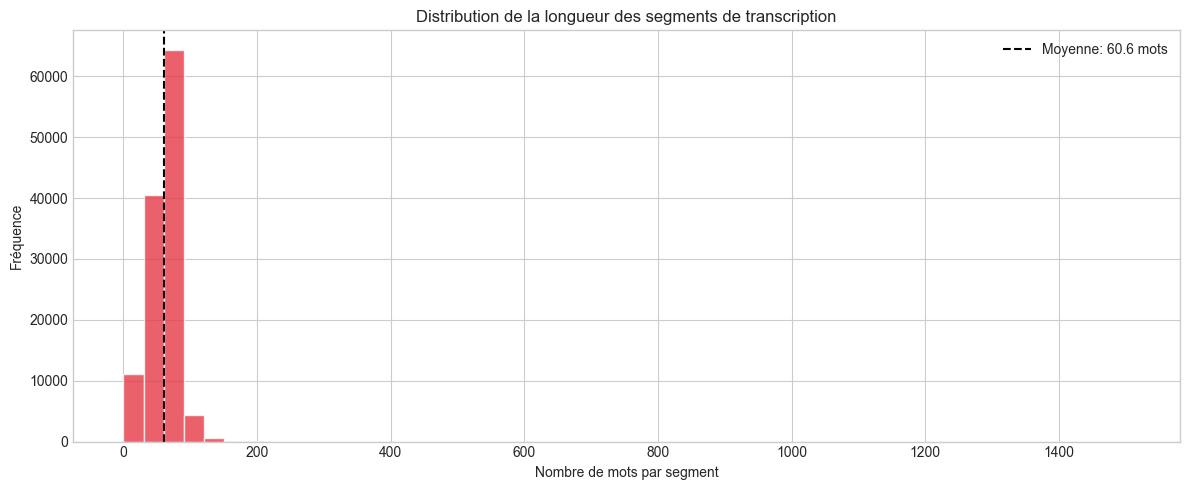

In [30]:
# Calcul de la longueur moyenne des phrases
transcriptions_df['word_count'] = transcriptions_df['text'].str.split().str.len()

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(transcriptions_df['word_count'].dropna(), bins=50, color='#E63946', edgecolor='white', alpha=0.8)
ax.axvline(transcriptions_df['word_count'].mean(), color='black', linestyle='--', 
           label=f"Moyenne: {transcriptions_df['word_count'].mean():.1f} mots")
ax.set_xlabel('Nombre de mots par segment')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution de la longueur des segments de transcription')
ax.legend()
plt.tight_layout()
plt.show()

---

## Partie 4 : Comparaison Trump vs Biden vs Kamala

On a également scrapé les discours de Biden et Kamala Harris pour comparer les styles.

In [35]:
# Chargement des données Biden/Harris
other_transcriptions = pd.read_parquet('../data/other_transcriptions_cleaned.parquet')
other_transcriptions['text'] = other_transcriptions['text'].str.replace(r"\[.*?\]", "", regex=True, flags=re.DOTALL).str.strip()
# on sépare Biden et kamala
biden_transcriptions = other_transcriptions[other_transcriptions['person_name'] == 'Joe Biden'].copy()
harris_transcriptions = other_transcriptions[other_transcriptions['person_name'] == 'Kamala Harris'].copy()
print(f"Taille du corpus :")
print(f"   Trump  : {len(transcriptions_df):,} segments")
print(f"   Biden  : {len(biden_transcriptions):,} segments")
print(f"   Harris : {len(harris_transcriptions):,} segments")

Taille du corpus :
   Trump  : 121,034 segments
   Biden  : 5,428 segments
   Harris : 1,206 segments


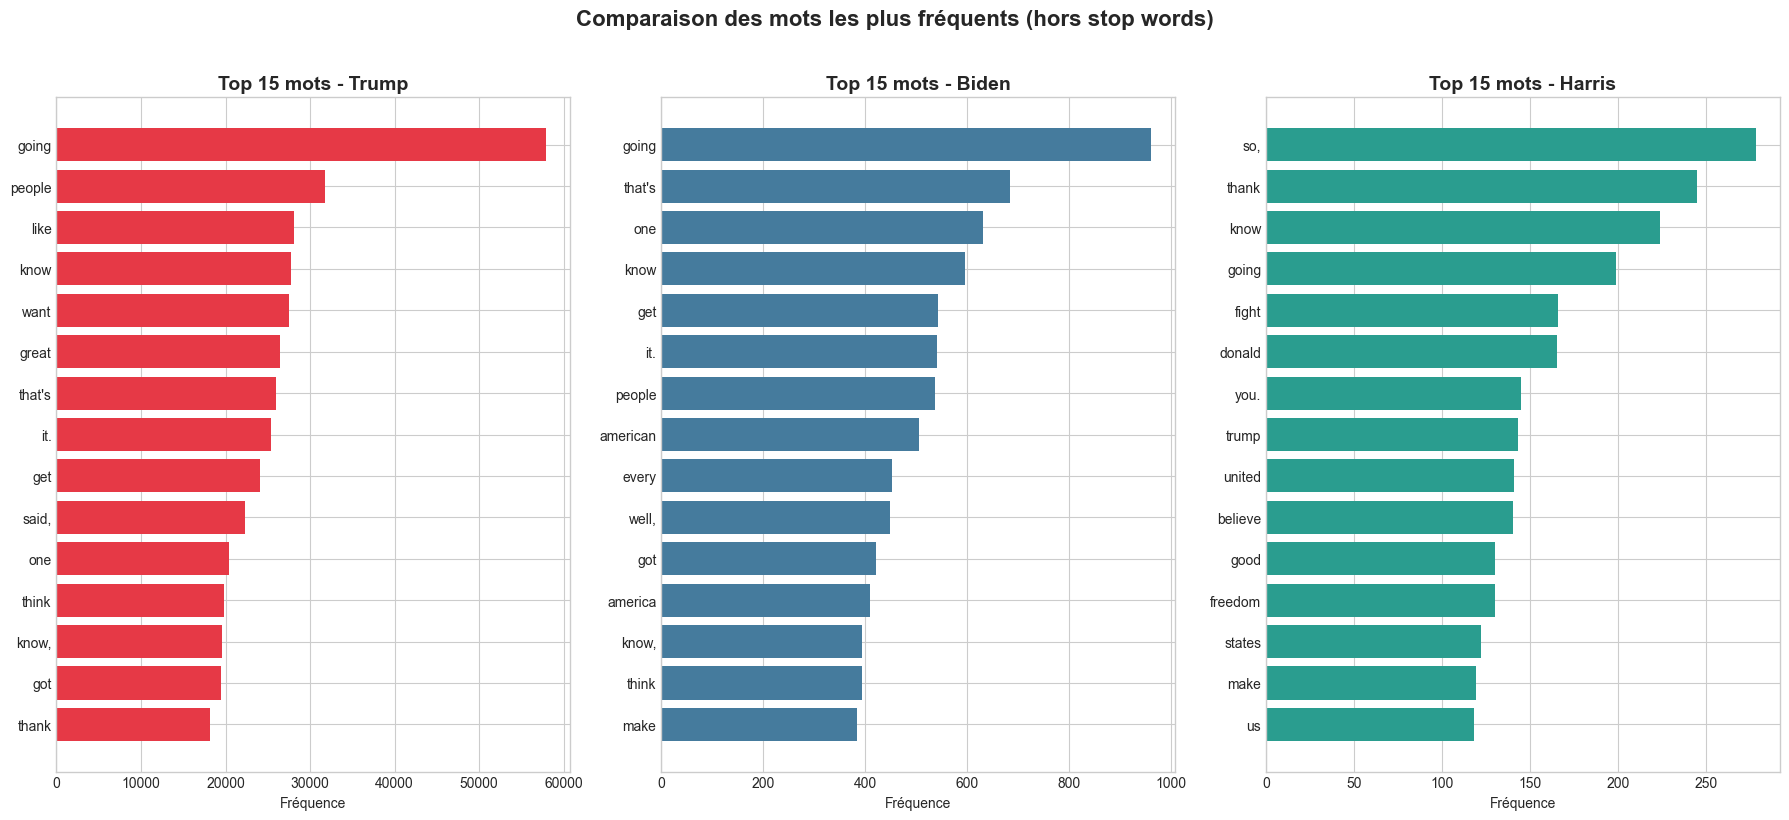

In [ ]:
def get_top_words(df, n=15):
    words = []
    for text in df['text'].dropna():
        words.extend(text.lower().split())
    counts = Counter(words)
    return [(w, c) for w, c in counts.most_common(300) if w not in stop_words and w not in punctuation and w not in nltk_artifacts][:n]
trump_top = get_top_words(transcriptions_df)
biden_top = get_top_words(biden_transcriptions)
harris_top = get_top_words(harris_transcriptions)
# Affichage côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
for ax, (data, name, color) in zip(axes, [(trump_top, 'Trump', '#E63946'),(biden_top, 'Biden', '#457B9D'),(harris_top, 'Harris', '#2A9D8F')]):
    words, counts = zip(*data)
    ax.barh(words, counts, color=color)
    ax.invert_yaxis()
    ax.set_title(f'Top 15 mots - {name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fréquence')

plt.suptitle('Comparaison des mots les plus fréquents (hors stop words)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 4.1 Mots caractéristiques de chaque candidat

In [ ]:
# Mots spécifiques à chaque candidat
trump_words = set(w for w, _ in trump_top)
biden_words = set(w for w, _ in biden_top)
harris_words = set(w for w, _ in harris_top)
only_trump = trump_words - biden_words - harris_words
only_biden = biden_words - trump_words - harris_words
only_harris = harris_words - trump_words - biden_words
print("Mots UNIQUES à Trump (dans le top 15) :")
print(f"   {only_trump}")
print()
print("Mots UNIQUES à Biden :")
print(f"   {only_biden}")
print()
print("Mots UNIQUES à Harris :")
print(f"   {only_harris}")

Mots UNIQUES à Trump (dans le top 15) :
   {'great', 'like', 'want', 'said,'}

Mots UNIQUES à Biden :
   {'american', 'every', 'well,', 'america'}

Mots UNIQUES à Harris :
   {'us', 'fight', 'you.', 'so,', 'states', 'trump', 'freedom', 'good', 'donald', 'believe', 'united'}


### 4.2 Comparaison de la longueur des interventions

C:\Users\nicol\AppData\Local\Temp\ipykernel_14124\2862997848.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['Trump', 'Biden', 'Harris'], patch_artist=True)


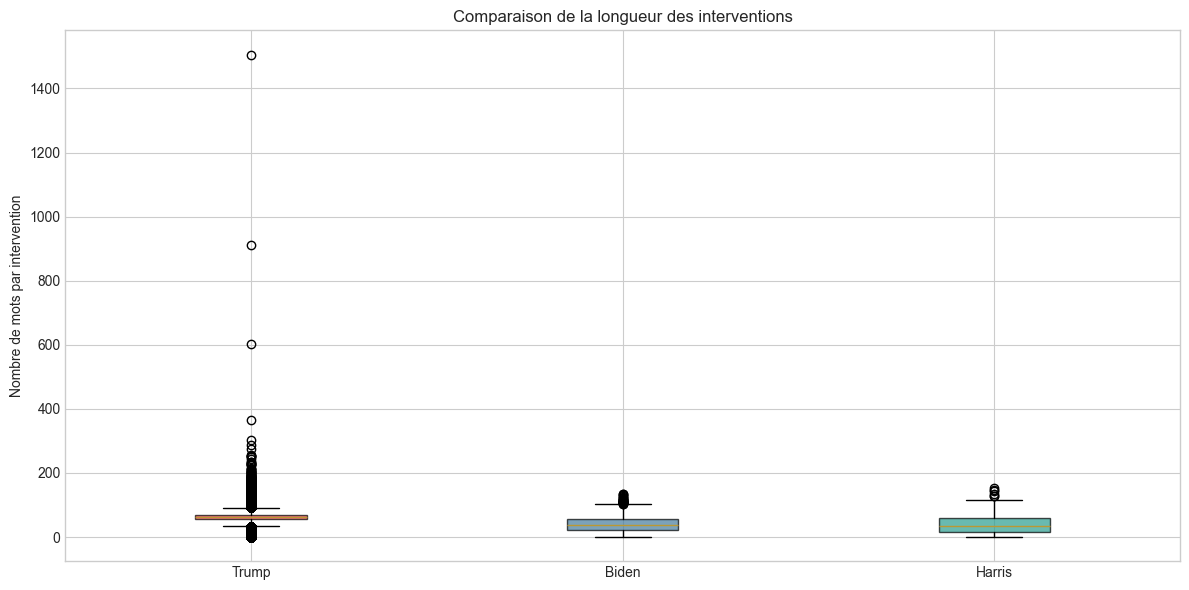

Moyenne de mots par segment :
   Trump  : 60.6
   Biden  : 39.3
   Harris : 38.8


In [ ]:
# Calcul de la longueur des segments
biden_transcriptions['word_count'] = biden_transcriptions['text'].str.split().str.len()
harris_transcriptions['word_count'] = harris_transcriptions['text'].str.split().str.len()

fig, ax = plt.subplots(figsize=(12, 6))

data = [transcriptions_df['word_count'].dropna(),biden_transcriptions['word_count'].dropna(),harris_transcriptions['word_count'].dropna()]

bp = ax.boxplot(data, labels=['Trump', 'Biden', 'Harris'], patch_artist=True)

colors = ['#E63946', '#457B9D', '#2A9D8F']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Nombre de mots par intervention')
ax.set_title('Comparaison de la longueur des interventions')
plt.tight_layout()
plt.show()

print(f"Moyenne de mots par segment :")
print(f"   Trump  : {transcriptions_df['word_count'].mean():.1f}")
print(f"   Biden  : {biden_transcriptions['word_count'].mean():.1f}")
print(f"   Harris : {harris_transcriptions['word_count'].mean():.1f}")

### 4.3 En donnant une phrase, peut-on prédire qui des trois l'a dit ?

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
# On crée des dataframes simplifiés avec juste le texte et le label
df_trump = transcriptions_df[['text']].copy()
df_trump['speaker'] = 'Trump'
df_biden = biden_transcriptions[['text']].copy()
df_biden['speaker'] = 'Biden'
df_harris = harris_transcriptions[['text']].copy()
df_harris['speaker'] = 'Harris'
# Équilibrage des classes (pour éviter le biais d'avoir trump tout le temps)
# On prend autant de Trump que de Biden (~5000) pour avoir un comparatif juste
n_samples = len(df_biden)
df_trump_sample = df_trump.sample(n=n_samples)
# On concatène tout (Harris est un peu moins présente, c'est ok)
df_all = pd.concat([df_trump_sample, df_biden, df_harris])
# Nettoyage rapide des NaNs éventuels
df_all = df_all.dropna(subset=['text'])
print(f"Jeu de données assemblé : {len(df_all)} exemples")
print(df_all['speaker'].value_counts())

#Vectorisation
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df_all['text'])
y = df_all['speaker']

#on fait un knn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, metric='cosine') #on prend cosine car c'est a priori le mieux en nlp
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"\nExactitude (Accuracy) : {accuracy_score(y_test, y_pred):.2%}")
print("\nDétails par candidat :")
print(classification_report(y_test, y_pred))

def predict_speaker(text):
    vec = vectorizer.transform([text])
    pred = knn.predict(vec)[0]
    # On peut aussi récupérer les probas si on veut
    return pred

# Quelques exemples
samples = [
    "Make America Great Again",
    "We have to build back better for the working class", 
    "We will fight for freedom and democracy"
]

print("-" * 30)
for s in samples:
    print(f"Phrase : '{s}' -> Prédit : {predict_speaker(s)}")

Jeu de données assemblé : 12062 exemples
speaker
Trump     5428
Biden     5428
Harris    1206
Name: count, dtype: int64

Exactitude (Accuracy) : 76.83%

Détails par candidat :
              precision    recall  f1-score   support

       Biden       0.76      0.85      0.80      1060
      Harris       0.54      0.73      0.62       234
       Trump       0.86      0.70      0.77      1119

    accuracy                           0.77      2413
   macro avg       0.72      0.76      0.73      2413
weighted avg       0.78      0.77      0.77      2413

------------------------------
Phrase : 'Make America Great Again' -> Prédit : Trump
Phrase : 'We have to build back better for the working class' -> Prédit : Biden
Phrase : 'We will fight for freedom and democracy' -> Prédit : Harris


In [47]:
France_lover=predict_speaker('I love France')
print(f"C'est {France_lover} qui nous aime le plus !")

C'est Harris qui nous aime le plus !


---

## Partie 5 : Modélisation par N-grammes

On utilise un modèle de trigrammes pour prédire le mot suivant dans une phrase.

### Principe

Un trigramme est une séquence de 3 mots consécutifs. On compte combien de fois chaque trigramme apparaît dans le corpus, puis on prédit le 3ème mot connaissant les 2 premiers.

In [49]:
from nltk.util import ngrams
# Construction du modèle de trigrammes
ngram_counts = defaultdict(Counter)
for text in transcriptions_df['text'].dropna():
    tokens = text.lower().split()
    for w1, w2, w3 in ngrams(tokens, 3):
        ngram_counts[(w1, w2)][w3] += 1

print(f"Nombre de contextes uniques (paires de mots) : {len(ngram_counts):,}")

Nombre de contextes uniques (paires de mots) : 1,033,351


In [50]:
def predict(starting_phrase, n_words=10):
    words = starting_phrase.lower().split()
    
    for _ in range(n_words):
        context = tuple(words[-2:])
        if context not in ngram_counts or not ngram_counts[context]:
            break
        next_word = ngram_counts[context].most_common(1)[0][0]
        words.append(next_word)
    
    return " ".join(words)

test_phrases = ['Make America Great', 'The fake news', 'We are going', 'China is']
for phrase in test_phrases:
    print(f"   '{phrase}' → {predict(phrase)}")

   'Make America Great' → make america great again. thank you, everybody. thank you. thank you. thank you.
   'The fake news' → the fake news media is so important. and i said, "you know, i
   'We are going' → we are going to be a great job. and i said, "you know,
   'China is' → china is building a massive tax cuts and reforms in american history.


On se rend compte que notre modèle prend peu de "risque" dans le sens où il prédit systématiquement la même chose, ce qui ne laisse pas la possibilité a de nouvelles phrases plus créatives

### 5.1 Ajout d'aléatoire pondéré

Le modèle greedy donne toujours la même réponse. On peut ajouter du hasard pondéré par les probabilités.

In [51]:
import random

def predict_random(starting_phrase, n_words=15):
    words = starting_phrase.lower().split()
    for _ in range(n_words):
        context = tuple(words[-2:])
        if context not in ngram_counts or not ngram_counts[context]:
            break
        candidates = ngram_counts[context].most_common()
        total = sum(c for _, c in candidates)
        r = random.random() * total
        cumul = 0
        for word, freq in candidates:
            cumul += freq
            if r <= cumul:
                words.append(word)
                break
    return " ".join(words)

# Génération de variations
print("5 variations aléatoires de 'Make America Great' :")
for i in range(5):
    print(f"   {i+1}. {predict_random('Make America Great')}")

5 variations aléatoires de 'Make America Great' :
   1. make america great again. thank you very much. and we're giving you open your borders, and they had
   2. make america great again. thank you very much. i pushed them like an outlier poll. everybody said they.
   3. make america great again. can you imagine? they come from areas of the saddest things that we have
   4. make america great again. no dream we have witnessed the pillaging and they're great. they're doing well. i'm
   5. make america great again. great.


### 5.2 D'autres exemples

In [53]:
prompts = [
    "I will",
    "The media",
    "Our country",
    "Sleepy Joe",
    "We love"
]

for prompt in prompts:
    print(f"   • \"{predict_random(prompt, 12)}\"")
    print()

   • "i will pass massive tax hiker in this weekends racists violence. ok, then you"

   • "the media executives. they're all democrat-run, all democrat-run, as we speak, the biden administration"

   • "our country like that. who would have been something very special. so i'm going"

   • "sleepy joe biden is the -- i don't think you're laughing at us. i"

   • "we love sheriff joe? so, was sheriff joe arpaio, who's a big lot of"



---

## Conclusion

Ce projet a permis de :

1. **Collecter** plus de 800 discours de Trump (et 60+ de Biden/Harris) via webscraping
2. **Analyser** le vocabulaire caractéristique de chaque candidat
3. **Visualiser** l'évolution temporelle, les catégories et les mots-clés
4. **Modéliser** le style de Trump avec un modèle N-gramme capable de compléter ses phrases

### Limites et pistes d'amélioration

- Le modèle N-gramme est simple mais produit parfois des boucles
- Un modèle plus avancé (LSTM, GPT-2) donnerait de meilleurs résultats
- L'analyse temporelle des discours pourrait être approfondie (évolution du vocabulaire selon les périodes)

---

## Annexe : Reproductibilité

Pour re-exécuter le scraping complet :

```bash
# 1. Installer les dépendances
pip install -r requirements.txt

# 2. Scraper les URLs (Trump)
python scripts/speech_url_scrap.py --candidate trump

# 3. Extraire les transcriptions
python scripts/process_speeches.py --candidate trump

# 4. Nettoyer les transcriptions
python scripts/clean_transcriptions.py --candidate trump

# Répéter pour Biden et Harris
python scripts/speech_url_scrap.py --candidate biden
python scripts/process_speeches.py --candidate biden
python scripts/clean_transcriptions.py --candidate biden
```